# Starbucks Capstone Challenge - Exploratory Data Analysis

## Introduction

As we now have a new perspective with the data. We'll look closer trying to answer our questions presented at the beginning.

## Setup

In [1]:
import sys

!{sys.executable} -m pip install -e ../ --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from sb_capstone.wrangling import (
    clean_transcript_group,
    tukey_rule
)

np.set_printoptions(suppress=True)
%matplotlib inline

In [3]:
transcript_group = pd.read_csv("../data/processed/transcript_group.csv")
transcript_group = clean_transcript_group(transcript_group)

transcript_group.head()

,id,wave,diffs,received,viewed,completed,purchased,amount,reward,non_offer_amount,...,mobile,social,gender,age,generation,group,income,membership_year,membership_month,membership_day
0,1,2,48.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2017,2,12
1,2,2,49.866737,False,False,False,False,0.00,0.0,0.00,...,False,False,F,55.0,boomers,middle_age,112000.0,2017,7,15
2,3,2,36.000000,True,True,False,False,0.00,0.0,0.00,...,True,False,U,NaN,NaN,NaN,NaN,2018,7,12
3,4,2,26.000000,True,True,True,True,19.67,0.0,29.72,...,True,True,F,75.0,silent,old,100000.0,2017,5,9
4,5,2,49.866737,False,False,False,True,0.00,0.0,3.50,...,False,False,U,NaN,NaN,NaN,NaN,2017,8,4


In [4]:
transcript_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   id                 102000 non-null  int64   
 1   wave               102000 non-null  int64   
 2   diffs              102000 non-null  float64 
 3   received           102000 non-null  bool    
 4   viewed             102000 non-null  bool    
 5   completed          102000 non-null  bool    
 6   purchased          102000 non-null  bool    
 7   amount             102000 non-null  float64 
 8   reward             102000 non-null  float64 
 9   non_offer_amount   102000 non-null  float64 
 10  mapped_offer       102000 non-null  category
 11  spendings          102000 non-null  float64 
 12  recommended_offer  102000 non-null  int64   
 13  offer_type         102000 non-null  category
 14  difficulty         102000 non-null  float64 
 15  duration           102000 non-null

## Preliminary Analysis

Before we look closely how effective the offers are, we'll have a closer look first at the data we are going to observe.

In [5]:
transcript_group.mapped_offer.value_counts()

0     25723
4      7677
5      7668
1      7658
6      7646
10     7632
8      7618
3      7617
7      7597
2      7593
9      7571
Name: mapped_offer, dtype: int64

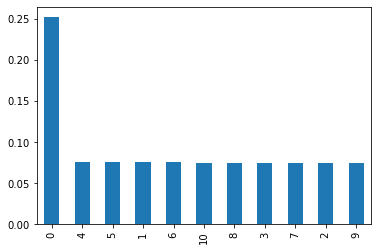

In [6]:
transcript_group.mapped_offer.value_counts(normalize=True).plot(kind="bar");

In [7]:
mean_offer_count = transcript_group.mapped_offer.value_counts()[1:].mean()
ctrl_count = transcript_group.mapped_offer.value_counts()[0]

mean_offer_count, ctrl_count

(7627.7, 25723)

In [8]:
mean_offer_count / (mean_offer_count + ctrl_count), ctrl_count / (mean_offer_count + ctrl_count)

(0.2287118411307709, 0.7712881588692292)

Here we can see, we have an almost balance offer groups, however, the control group is more than 3 times the treatment groups. Let's take note this for now.

In [9]:
transcript_group.received.value_counts()

True     76277
False    25723
Name: received, dtype: int64

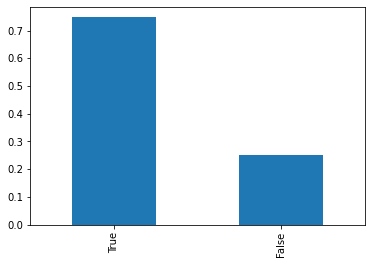

In [10]:
transcript_group.received.value_counts(normalize=True).plot(kind="bar");

If we are going to test the effectiveness of all offers in general, we can also see that the treatment group is also 3 times more than the control group.

## Q1: Which offer yields the best results?

### Incremental Response Rate

The metric we are going to measure is the Incremental Response Rate. To retrieve this we need to extract first the customers who:

* Given offers, and successfully completed the offer
* Not given offers, and still purchased product

We are going to call this value as `X`. 

In [11]:
transcript_group.loc[transcript_group.received, "purchased"] = transcript_group.viewed & transcript_group.completed
transcript_group.loc[~transcript_group.received, "purchased"] = transcript_group.non_offer_amount > 0

transcript_group.groupby("received").purchased.value_counts()

received  purchased
False     False        13425
          True         12298
True      False        47860
          True         28417
Name: purchased, dtype: int64

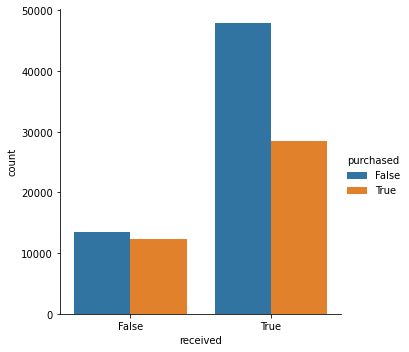

In [12]:
sns.catplot(data=transcript_group, kind="count", x="received", hue="purchased", ci=None);

Visually, the offers are not so good, but, there maybe some things that we don't see like the sample size difference between the two.

In [13]:
transcript_treat = transcript_group[transcript_group.received]
transcript_ctrl = transcript_group[~transcript_group.received]

Starting here, we are going to refer the number of customers as `n`.

To calculate the response rate, here's the formula.

$$ IRR = \frac{X_{tr}}{n_{tr}} - \frac{X_{ct}}{n_{ct}} $$

or

$$ IRR = \bar{X}_{tr} - \bar{X}_{ct} $$

In [14]:
irr = transcript_treat.purchased.mean() - transcript_ctrl.purchased.mean()
irr

-0.1055434871167969

This `irr` difference alone shows the rate are note that promising.

### Invariant Test

Looking at the samples above, first noticeable is we have a good amount of samples (greater than 5000), and with large samples, it also have large statistical power. We may no longer needed to check normality test through `shapiro`.

Another thing we can look at is the proportion of sample sizes between control and treatment group.

The first is the comparison between control group with individual offers.

As we can see we have 25723 for control group, which is more than 3 times the average for individual treatment with 7627.7. With this, a good amount of control group, helps us establish a good baseline.

In [15]:
transcript_group.received.value_counts(normalize=True)

True     0.747814
False    0.252186
Name: received, dtype: float64

The next is the comparison between control group and all the combined offers.

The treatment group is at 76277 and the control group is 25723. This puts us at 75 (treatment) : 25 (control). We are going to take note this for now, based on the study done here:

[Control Size](https://www.markhw.com/blog/control-size)

25% is just at the sweet spot, before the statistical power drops significantly.

### Statistical Test

Since the metrics we've chosen is whether the purchase is successful with and without offer, this corresponds to a Bernoulli population. Also, as inspected above, our `X` is more than 10, therefore we have enough samples to perform the `z-test`.

For this test we are going to use the following.

**Significance Level:** 0.05

**Type of Test:** Z Test

**Hypothesis:**

$$ H_0: \bar{X}_{tr} \leq \bar{X}_{ct} $$

$$ H_1: \bar{X}_{tr} > \bar{X}_{ct} $$

In [16]:
z_score, p_value = sm.stats.ztest(transcript_treat.purchased, transcript_ctrl.purchased, alternative="larger")

print(f"Z-Score: {z_score}")
print(f"P-Value: {p_value}")

Z-Score: -30.022095386446754
P-Value: 1.0


The P-Value at 1.0 is greater than the significance level. The offers did not improved the IRR.

Applying the same hypothesis and variables to individual offers against our control group, let's see which offer yields the best results.

In [17]:
scores = []

for i in np.arange(1, 11):
    z_score, p_value = sm.stats.ztest(transcript_treat[transcript_treat.mapped_offer == i].purchased, transcript_ctrl.purchased, alternative="larger")
    scores.append([i, z_score, p_value])

scores = pd.DataFrame(scores, columns=["offer", "z_score", "p_value"])

scores


,offer,z_score,p_value
0,1,-20.961817,1.000000e+00
1,2,-17.135207,1.000000e+00
2,3,-39.711281,1.000000e+00
3,4,-31.713629,1.000000e+00
4,5,-49.787303,1.000000e+00
5,6,14.838436,4.133016e-50
6,7,20.944177,1.060145e-97
7,8,-10.962533,1.000000e+00
8,9,-1.226650,8.900230e-01
9,10,-31.671633,1.000000e+00


Among the offers, the one that yields the best results in order are **offers 7 and 6**.

These are both discount types of **difficulty 10** and **reward of 2**.

### Practical Test

Let's now perform practical test for our `irr`. Here are the variables we are going to use.

**Practical Significance Boundary**: 0.10

Let's say, we have an average price of product at 8, and given the cost of promotion of 0.15 each, on 4 channels, 0.6 in total. We need an increase of 0.075 `irr` to breakeven, for this exercise, we'll adjust it to 0.10 to say, we still need to have a revenue.

Here we are going to compute the confidence interval margin of error.

$$ m = Z * SE_{unpool} $$

Since, we don't have an equal proportion population, we are going to use the formula for unpooled standard error.

$$ SE_{unpool} = \sqrt{\frac{S_{ct}^2}{n_{ct}}+\frac{S_{tr}^2}{n_{tr}}} $$

Where S is the standard deviation of each group. With the raise to 2, this is also similar to the variance of each group.

Lastly, the Z of an upper-tailed distribution at 95% is 1.645.

In [18]:
def se_unpooled(x, y):
    return np.sqrt((x.var() / len(x)) + (y.var() / len(y)))

def z_conf_int(x, y, alpha=0.05, sides="one"):
    se_up = se_unpooled(x, y)

    if sides == "2":
        alpha = alpha / 2

    z = stats.norm.ppf(1 - alpha)

    m = z * se_up
    
    d = x.mean() - y.mean()

    return (d-m, d+m), se_up, z, m, d

In [19]:
ci, se_up, z, m, d = z_conf_int(transcript_treat.purchased, transcript_ctrl.purchased)

print(f"Confidence Interval: {ci}")
print(f"Standard Error: {se_up}")
print(f"Z-Score: {z}")
print(f"Margin of Error: {m}")
print(f"Difference: {d}")

Confidence Interval: (-0.11142030390593163, -0.09966667032766216)
Standard Error: 0.0035728509168482508
Z-Score: 1.6448536269514722
Margin of Error: 0.0058768167891347384
Difference: -0.1055434871167969


Using unpooled SE to get the margin of error, we can see that both range didn't meet the practical significance boundary. Therefore, we can say that the offers are not statistically significant.

Let's examine the results on individual offers.

In [20]:
intervals = []

for i in np.arange(1, 11):
    ci, se_up, z, m, d = z_conf_int(transcript_treat[transcript_treat.mapped_offer == i].purchased, transcript_ctrl.purchased)

    intervals.append([i, ci[0], ci[1], se_up, z, m, d]) 

intervals = pd.DataFrame(intervals, columns=["offer", "lower", "upper", "se_up", "z_score", "moe", "diff"])
intervals

,offer,lower,upper,se_up,z_score,moe,diff
0,1,-0.145083,-0.124501,0.006256,1.644854,0.010291,-0.134792
1,2,-0.121356,-0.100471,0.006349,1.644854,0.010443,-0.110913
2,3,-0.259344,-0.240496,0.005729,1.644854,0.009424,-0.249920
3,4,-0.211132,-0.191454,0.005982,1.644854,0.009839,-0.201293
4,5,-0.315856,-0.298390,0.005309,1.644854,0.008733,-0.307123
5,6,0.085706,0.106943,0.006456,1.644854,0.010619,0.096324
6,7,0.125313,0.146353,0.006396,1.644854,0.010520,0.135833
7,8,-0.081744,-0.060581,0.006433,1.644854,0.010582,-0.071163
8,9,-0.018747,0.002726,0.006527,1.644854,0.010737,-0.008010
9,10,-0.211353,-0.191637,0.005993,1.644854,0.009858,-0.201495


While 6 and 7 offers passed the statistical test, looking at the practical significance, given the boundary, only offer 7 passed on both ends of the range.

The difference of Offer 7 with Offer 6 is that the former has higher duration. This is a good sign that the offer maybe working better at a longer duration.

### Conclusion

The combining all the efforts, the offers are not effective at improving the IRR. Individually however, **Offer 7** with a difficulty of 10, reward of 2, and a duration of 10, is the only offer currently effective, perhaps across demographics.

Offer 7 is perhaps appealing as it has a decent difficulty everyone can afford and the reward is no brainer.

## Q2: Which offer provides the best revenue?

### Incremental Revenue Rate

Since we have a cost in sending out promotions, plus the reward given to the customer, we need to ensure not only the response rate, but we also need to test if we are able to generate enough revenue. Since we don't have a good balance of our groups, we are going to take the revenue rate instead (mean of revenue). The revenue are computed differently for control and treatment groups.

Assuming that the cost of sending out offers is `0.15` per channel.

$$ rev_{tr} = amt_{tr} - rwd_{tr} - ((ch_{email} + ch_{web} + ch_{mobile} + ch_{social}) * 0.15) $$

$$ rev_{ct} = amt_{ct} $$

For the treatment group, getting just the amount spent for offer will not be good enough to test of revenue, what we want here is how the offers are influenced by their spending patterns during the promotions, therefore, we include `non_offer_amout` values as well.

In our dataset we separated offer and non offer amount. For treatment, the amount we are going to use is `amount` while for control we are going to use `amount_non_offer`.

In [21]:
transcript_group.loc[transcript_group.received, "revenue"] = (transcript_treat.amount + transcript_treat.non_offer_amount) - transcript_treat.reward - (transcript_treat.email * 0.15 + transcript_treat.web * 0.15 + transcript_treat.mobile * 0.15 * transcript_treat.social * 0.15)
transcript_group.loc[~transcript_group.received, "revenue"] = transcript_ctrl.non_offer_amount

transcript_group.groupby("received").revenue.mean()

received
False    10.053857
True     17.443542
Name: revenue, dtype: float64

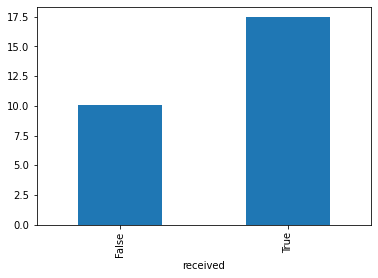

In [22]:
transcript_group.groupby("received").revenue.mean().plot(kind="bar");

Visually, there might be a significant difference for those who received offers compared to those who didn't. We can look closer in a while using statistical analysis.

### Invariant Test

Similar to our previous test, one very noticeable is that the sample size are not in equal proportion. However, we have an ample amount of sample size, we don't need to check normality test.

The control sizes is within acceptable range as well, with that we can proceed with our test.

### Statistical Test

The metrics we've choosen is difference in mean, therefore, this does not correspond with Bernoulli population. Another noticeable thing as well is that we have unequal proportion between groups, so we are going to make use of unpooled way of calculating standard error. Lastly, the population variance is also unknown, therefore the test that we'll be doing is a `t-test`.

For this we are going to use the following.

**Significance Level:** 0.05

**Type of TesT:** T Test

**Hypothesis:**

We are going to use `X` again to represent the mean revenue per group.

$$ H_0: \bar{X}_{tr} - \bar{X}_{ct} \leq 0 $$
$$ H_1: \bar{X}_{tr} - \bar{X}_{ct} > 0 $$


In [23]:
transcript_treat = transcript_group[transcript_group.received]
transcript_ctrl = transcript_group[~transcript_group.received]

In [24]:
t_score, p_value, df = sm.stats.ttest_ind(transcript_treat.revenue, transcript_ctrl.revenue, usevar="unequal", alternative="larger")

print(f"T-Score:            {t_score}")
print(f"P-Value:            {p_value}")
print(f"Degrees of Freedom: {df}")

T-Score:            29.52741084129509
P-Value:            1.3916953734223033e-190
Degrees of Freedom: 61287.09655932033


Our P-Value here is close to zero and way less than our significance level. Therefore we **reject the null hypothesis**. The offers somehow influenced the customers to spend more.

In [25]:
scores = []

for i in np.arange(1, 11):
    t_score, p_value, df = sm.stats.ttest_ind(transcript_treat[transcript_treat.mapped_offer == i].revenue, transcript_ctrl.revenue, usevar="unequal", alternative="larger")

    scores.append([i, t_score, p_value, df])

scores = pd.DataFrame(scores, columns=["offer", "t_score", "p_value", "df"])
scores

,offer,t_score,p_value,df
0,1,13.434090,4.353748e-41,9863.800257
1,2,11.795935,3.359569e-32,9828.343788
2,3,9.948234,1.600805e-23,11241.021329
3,4,8.793543,8.377337e-19,10515.334494
4,5,7.898408,1.552929e-15,10546.340274
5,6,20.488827,1.025337e-91,9951.663224
6,7,23.107796,3.570126e-115,9158.603179
7,8,13.779222,3.647371e-43,11799.914620
8,9,14.180886,1.721899e-45,9575.729538
9,10,12.963911,1.940302e-38,10348.595753


All offers **reject the null hypothesis**. It shows that having offers, may not be directly getting the offer itself, influences customers to spend more during those period.

### Practical Test

Now on the practical side, we are going to assume to buy an additional coffee for every customer that has an offer.

In [26]:
transcript_group.amount.mean(), transcript_group.non_offer_amount.mean()

(8.181790980392158, 9.22460088235294)

With the mean amounts above, we'll set for now the practical significant boundary at 10.0.

**Practical Significance Boundary**: 10.0

**T at 95%**: 1.645

To calculate the margin of error, we are still going to follow the same formula above, revising our method to use T-Score.

In [27]:
def t_conf_int(x, y, alpha=0.05, sides="one"):
    se_up = se_unpooled(x, y)

    if sides == "2":
        alpha = alpha / 2

    df = ((x.var() / len(x) + y.var() / len(y)) ** 2) / \
            ((x.var() / len(x)) ** 2 / (len(x) - 1) + \
                (y.var() / len(y)) ** 2 / (len(y) - 1))

    t = stats.t.ppf(1 - alpha, df=df)

    m = t * se_up

    d = x.mean() - y.mean()

    return (d-m, d+m), se_up, t, m, d, df

In [28]:
ci, se_up, t, m, d, df = t_conf_int(transcript_treat.revenue, transcript_ctrl.revenue)

print(f"Confidence Interval: {ci}")
print(f"Standard Error:      {se_up}")
print(f"T-Score:             {t}")
print(f"Margin of Error:     {m}")
print(f"Difference:          {d}")
print(f"Degrees of Freedom:  {df}")


Confidence Interval: (6.978029066341136, 7.801340935593416)
Standard Error:      0.2502652549079111
T-Score:             1.6448784901348554
Margin of Error:     0.4116559346261396
Difference:          7.389685000967276
Degrees of Freedom:  61287.09655932046


Even though the intervals are in the positive direction, they failed to reach our practical significance boundary.

Moving on to individual offers.

In [29]:
intervals = []

for i in np.arange(1, 11):
    ci, se_up, t, m, d, df = t_conf_int(transcript_treat[transcript_treat.mapped_offer == i].revenue, transcript_ctrl.revenue)

    intervals.append([i, ci[0], ci[1], se_up, t, m, d, df])

intervals = pd.DataFrame(intervals, 
    columns=["offer", "lower", "upper", "se_up", "t_score", "moe", "diff", "dof"])
    
intervals

,offer,lower,upper,se_up,t_score,moe,diff,dof
0,1,6.591651,8.431204,0.559132,1.645008,0.919776,7.511427,9863.800257
1,2,5.623977,7.446765,0.554036,1.645009,0.911394,6.535371,9828.343788
2,3,3.782596,5.281367,0.455556,1.644989,0.749385,4.531981,11241.021329
3,4,3.601982,5.259733,0.503876,1.644999,0.828876,4.430857,10515.334494
4,5,3.131539,4.779081,0.500773,1.644998,0.823771,3.955310,10546.340274
5,6,10.334045,12.138305,0.548405,1.645007,0.902130,11.236175,9951.663224
6,7,13.891061,16.020429,0.647216,1.645020,1.064684,14.955745,9158.603179
7,8,5.230801,6.649032,0.431078,1.644983,0.709116,5.939916,11799.914620
8,9,7.266238,9.173253,0.579636,1.645013,0.953508,8.219745,9575.729538
9,10,5.793243,7.477131,0.511820,1.645001,0.841944,6.635187,10348.595753


Given a high practical significance boundary of 10.0, only offer 6 and 7 passed the practical test, having offer 7 performing better.

### Conclusion

The offers shows a positive impact as the customers spends more when given offers. At this angle, even the company is risking to lose money offering rewards in the offers, we are able to influence the customers to buy more.

However, it's still not enough as the result in general didn't meet the practical significance boundary, except for offers 6 and 7. Our recommendations are, to remove or adjust the offers that are not working, and offer more those types that are effective, also, we may wish to target as well customers who are likely affected by offers and buys more.

## Next Steps

We left the third question to be focused more on applying machine learning to improve our offer and forecast. It was consistent that Offers 6 and 7 are the best performing ones. These are both discount type at 10 difficulty and 2 rewards.

Lastly, we are going to create a library class that consumers can use to tune who receives offer catering new and existing users.